# Predict Crimes in Vancouver - Dense Neural Network

We compare dense neural networks on six different models:
1. Data without the `part_of_day` feature.
2. Data without the `part_of_day` feature and class weights.
3. Data without the `part_of_day` feature and oversampling.
4. Data with the `part_of_day` feature.
5. Data with the `part_of_day` feature and class weights.
6. Data with the `part_of_day` feature and oversampling.


We start with following [7] to migrate an Sklearn training pipeline to Tensorflow Keras.


Then, we largely follow [6] to classify our highly imbalanced dataset using Keras.

## Research Sources
[1] Hossain, S., Abtahee, A., Kashem, I., Hoque, M.M., Sarker, I.H. (2020). Crime Prediction Using Spatio-Temporal Data. In: Chaubey, N., Parikh, S., Amin, K. (eds) Computing Science, Communication and Security. COMS2 2020. Communications in Computer and Information Science, vol 1235. Springer, Singapore. https://doi.org/10.1007/978-981-15-6648-6_22

[2] Rotaru, V., Huang, Y., Li, T. et al. Event-level prediction of urban crime reveals a signature of enforcement bias in US cities. Nat Hum Behav 6, 1056–1068 (2022). https://doi.org/10.1038/s41562-022-01372-0

[3] CSV to Shapefile with pyshp: https://glenbambrick.com/2016/01/09/csv-to-shapefile-with-pyshp/

[4] Machine Learning with Datetime Feature Engineering: Predicting Healthcare Appointment No-Shows: https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96

[5] Fine tuning a classifier in scikit-learn: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

[6] Classification on imbalanced data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

[7] Migrating an Sklearn model training Pipeline to Tensorflow Keras: https://medium.com/mlearning-ai/migrating-an-sklearn-model-training-pipeline-to-tensorflow-keras-d248754f991d

## Libraries and Functions

In [35]:
import pandas as pd
pd.options.display.max_columns = None  # display all dataframe columns in the notebook
import numpy as np
import csv
import math
import os
import tempfile

# models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

# transformers
import tensorflow as tf
from tensorflow.keras.layers import IntegerLookup, StringLookup
from easyflow.preprocessing.pipeline import FeatureUnion
from easyflow.preprocessing import FeatureInputLayer

# metrics
import sklearn
from sklearn.metrics import precision_recall_curve, roc_auc_score, balanced_accuracy_score, average_precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)  # set standard figure size
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

# suppress warnings
import warnings
warnings.simplefilter(action='ignore')

In [2]:
## taken from [6]

# plot loss
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val ' + label, linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [3]:
## taken from [6]

# plot metrics
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [6]:
## taken from [4]

# calculate specificity
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_actual, (y_pred >= thresh))
    accuracy = accuracy_score(y_actual, (y_pred >= thresh))
    recall = recall_score(y_actual, (y_pred >= thresh))
    average_precision = average_precision_score(y_actual, (y_pred >= thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    f1 = f1_score(y_actual, (y_pred >= thresh))
    print('ROC AUC: %.3f'%auc)
    print('Balanced accuracy: %.3f'%balanced_accuracy)
    print('Accuracy: %.3f'%accuracy)
    print('Recall: %.3f'%recall)
    print('Average precision: %.3f'%average_precision)
    print('Specificity: %.3f'%specificity)
    print('F1: %.3f'%f1)
    print(' ')

In [7]:
## taken from [5]

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

## Model 1

Use the data without the `part_of_day` feature, which reduces the data size to a quarter.

We apply a dense neural network with careful bias initialization.

In [411]:
# read data
crime_df_full = pd.read_csv('data/crime_df_classification_without_partofday.csv')
crime_df_full.head()

,dauid,neighbourhood,date,year,month,day,weekday,season,crime
0,59154181,Central Business District,2019-01-01,2019,1,1,Tuesday,winter,0
1,59154181,Central Business District,2019-01-02,2019,1,2,Wednesday,winter,1
2,59154181,Central Business District,2019-01-03,2019,1,3,Thursday,winter,0
3,59154181,Central Business District,2019-01-04,2019,1,4,Friday,winter,0
4,59154181,Central Business District,2019-01-05,2019,1,5,Saturday,winter,0


In [412]:
# data size
crime_df_full.shape

(1120116, 9)

In [413]:
# data types
crime_df_full.dtypes

dauid             int64
neighbourhood    object
date             object
year              int64
month             int64
day               int64
weekday          object
season           object
crime             int64
dtype: object

In [414]:
# convert date column to datetime type
crime_df_full['date'] = pd.to_datetime(crime_df_full['date'])
crime_df_full.dtypes

dauid                     int64
neighbourhood            object
date             datetime64[ns]
year                      int64
month                     int64
day                       int64
weekday                  object
season                   object
crime                     int64
dtype: object

In [415]:
# set target column
target_col = 'crime'

We model on a single neighbourhood. We choose the `Central Business District` as, we saw earlier, it has by far the highest amount of reported crimes.

In [416]:
# separate features and target
X = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'].drop(columns=[target_col,'date','neighbourhood'])
y = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'][target_col]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 94, stratify = y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 94, stratify = y_train, test_size=0.2)

# print their shapes
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(57740, 6)
(14436, 6)
(18044, 6)
(57740,)
(14436,)
(18044,)


In [417]:
# define variable types
CATEGORICAL_FEATURES = ['dauid', 'year', 'month', 'day']
STRING_CATEGORICAL_FEATURES = ['weekday','season']

In [418]:
# create a feature input layer
feature_layer_inputs = FeatureInputLayer({
    'dauid': tf.int64,
    'year': tf.int64,
    'month': tf.int64,
    'day': tf.int64,
    'weekday': tf.string,
    'season': tf.string
})

# implement a similar preprocessing pipeline to sklearn
preprocessor = FeatureUnion(
    feature_preprocessor_list = [
        ('cat', IntegerLookup(), CATEGORICAL_FEATURES),
        ('str_cat', StringLookup(), STRING_CATEGORICAL_FEATURES)
    ]
)

# update the preprocessing layer states
preprocessor.adapt(X_train)

In [666]:
## taken from [6] and slightly modified

# define the model and metrics:
# a simple neural network with a densly connected hidden layer, 
# a dropout layer to reduce overfitting, 
# and an output sigmoid layer that returns the probability of crime

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias='zeros', inputs=feature_layer_inputs):
    if output_bias!='zeros':
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    preprocessed_inputs = preprocessor(inputs)
    x = layers.Dense(12, activation="relu")(preprocessed_inputs)
    x = layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
    model = tf.keras.Model(inputs=feature_layer_inputs, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return model

In [667]:
# build the model
EPOCHS = 300
BATCH_SIZE = 2048
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

model = make_model()
model.summary()

Model: "model_119"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dauid (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 day (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 month (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 season (InputLayer)            [(None, 1)]          0           []                               
                                                                                          

In [668]:
# test run the model
model.predict(dict(X_train[:10]))

1/1 [==============================] - 0s 89ms/step


array([[1.2154190e-12],
       [8.6219152e-06],
       [9.8147933e-13],
       [2.5613368e-14],
       [1.2847165e-07],
       [5.2913298e-14],
       [1.5294875e-06],
       [4.0234557e-08],
       [1.9340052e-03],
       [3.6855663e-06]], dtype=float32)

In [669]:
# compute loss
results = model.evaluate(dict(X_train), y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 4.6922


### Set the correct initial bias

Our dataset is imbalanced, so we should set the output layer's bias to reflect that. This can help with initial convergence.

The correct bias should be:

In [670]:
initial_bias = np.log([y_train.value_counts()[1]/y_train.value_counts()[0]])
initial_bias

array([-1.08388753])

If we set that as the initial bias, the model should give more reasonable initial guesses.

In [671]:
# test run the model
model = make_model(output_bias=initial_bias)
model.predict(dict(X_train[:10]))

1/1 [==============================] - 0s 96ms/step


array([[1.0060449e-03],
       [9.7943974e-01],
       [1.0738241e-05],
       [8.2116673e-04],
       [9.9999988e-01],
       [1.6264099e-04],
       [9.9408680e-01],
       [5.0299925e-01],
       [5.8073813e-01],
       [4.4083256e-02]], dtype=float32)

In [672]:
# compute loss
results = model.evaluate(dict(X_train), y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 3.2408


In [673]:
# checkpoint the initial weights
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses:

In [674]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(dict(X_train), y_train, batch_size=BATCH_SIZE, epochs=20,
                              validation_data=(dict(X_val), y_val), verbose=0)

In [675]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(dict(X_train), y_train, batch_size=BATCH_SIZE, epochs=20,
                              validation_data=(dict(X_val), y_val), verbose=0)

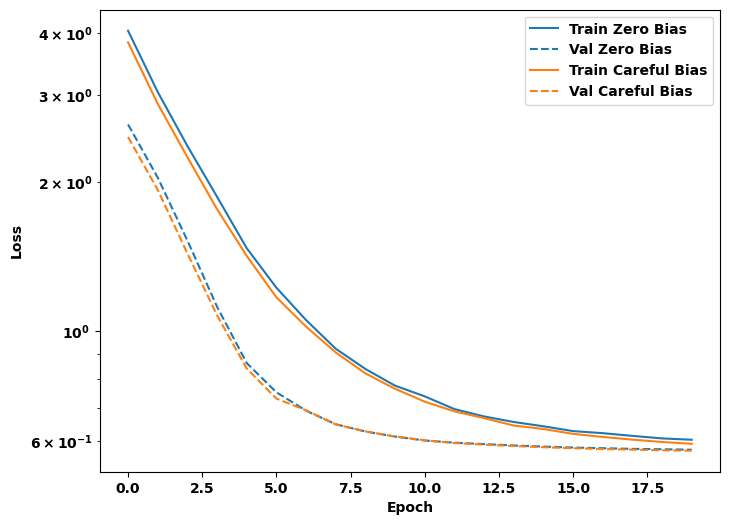

In [676]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The careful initialization gives a slight advantage.

### Train the model

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(dict(X_train), y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                             callbacks=[early_stopping], validation_data=(dict(X_val), y_val))

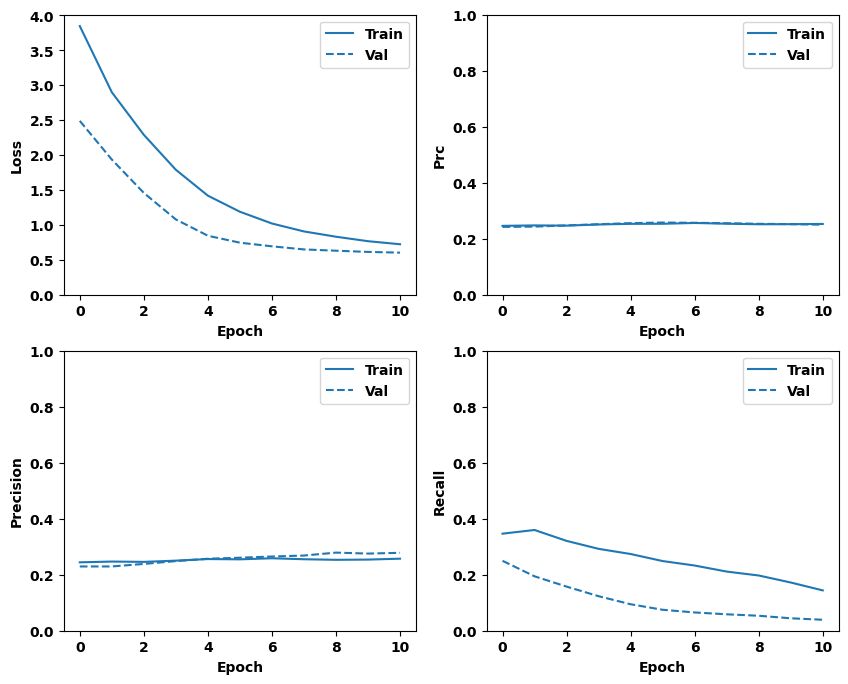

In [678]:
# training history
plt.figure(figsize=(10, 8))
plot_metrics(baseline_history)

In [679]:
# predict
train_predictions_baseline = model.predict(dict(X_train), batch_size=BATCH_SIZE).flatten()
test_predictions_baseline = model.predict(dict(X_test), batch_size=BATCH_SIZE).flatten()

9/9 [==============================] - 0s 3ms/step


In [680]:
# evaluate metrics
baseline_results = model.evaluate(dict(X_test), y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

loss :  0.7390143275260925
tp :  362.0
fp :  950.0
tn :  12533.0
fn :  4199.0
accuracy :  0.7146419882774353
precision :  0.27591463923454285
recall :  0.07936856150627136
auc :  0.51857590675354
prc :  0.26193517446517944


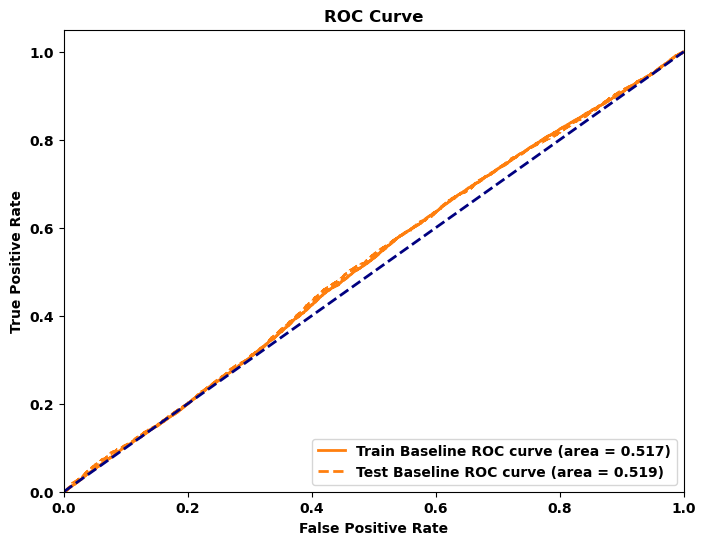

In [681]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test_baseline, tpr_test_baseline, _ = roc_curve(y_test, test_predictions_baseline)
roc_auc_test_baseline = auc(fpr_test_baseline, tpr_test_baseline)
fpr_train_baseline, tpr_train_baseline, _ = roc_curve(y_train, train_predictions_baseline)
roc_auc_train_baseline = auc(fpr_train_baseline, tpr_train_baseline)

plt.figure()
lw = 2
plt.plot(fpr_train_baseline, tpr_train_baseline, color=colors[1], lw=lw, label="Train Baseline ROC curve (area = %0.3f)" % roc_auc_train_baseline)
plt.plot(fpr_test_baseline, tpr_test_baseline, color=colors[1], linestyle='--', lw=lw, label="Test Baseline ROC curve (area = %0.3f)" % roc_auc_test_baseline)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [682]:
# standard threshold
thresh=0.5

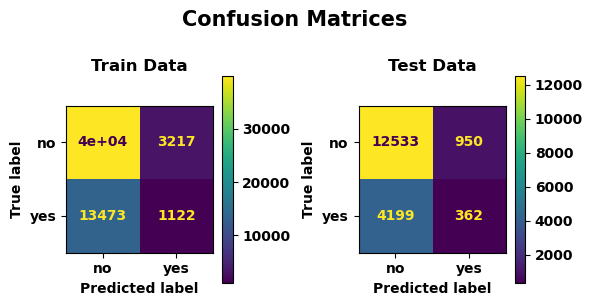

In [683]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_baseline >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_baseline >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [684]:
# scores on train data
print_report(y_train, train_predictions_baseline, thresh)

ROC AUC: 0.517
Balanced accuracy: 0.501
Accuracy: 0.711
Recall: 0.077
Average precision: 0.253
Specificity: 0.925
F1: 0.119
 


In [685]:
# scores on test data
print_report(y_test, test_predictions_baseline, thresh)

ROC AUC: 0.519
Balanced accuracy: 0.504
Accuracy: 0.715
Recall: 0.079
Average precision: 0.255
Specificity: 0.930
F1: 0.123
 


### Threshold Tuning, based on

#### F1 Score

In [686]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [687]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (test_predictions_baseline >= t).astype(int)) for t in thresholds]

In [688]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.017, F-score=0.404


In [689]:
# set threshold
thresh = thresholds[ix]
thresh

0.017

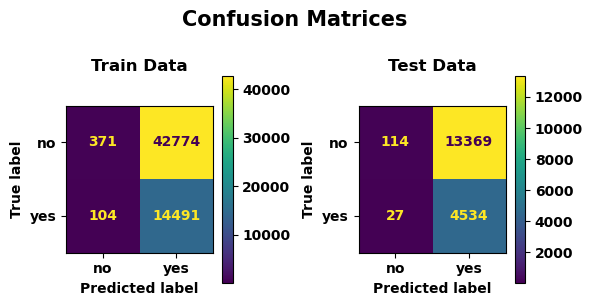

In [690]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_baseline >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_baseline >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [691]:
# scores on train data
print_report(y_train, train_predictions_baseline, thresh)

ROC AUC: 0.517
Balanced accuracy: 0.501
Accuracy: 0.257
Recall: 0.993
Average precision: 0.253
Specificity: 0.009
F1: 0.403
 


In [692]:
# scores on test data
print_report(y_test, test_predictions_baseline, thresh)

ROC AUC: 0.519
Balanced accuracy: 0.501
Accuracy: 0.258
Recall: 0.994
Average precision: 0.253
Specificity: 0.008
F1: 0.404
 


#### ROC AUC Curve

In [693]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_baseline)

In [694]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.102883


In [695]:
# set threshold
thresh = best_thresh
thresh

0.10288311

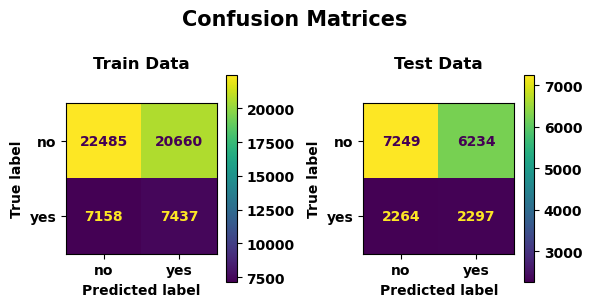

In [696]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_baseline >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_baseline >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [697]:
# scores on train data
print_report(y_train, train_predictions_baseline, thresh)

ROC AUC: 0.517
Balanced accuracy: 0.515
Accuracy: 0.518
Recall: 0.510
Average precision: 0.259
Specificity: 0.521
F1: 0.348
 


In [698]:
# scores on test data
print_report(y_test, test_predictions_baseline, thresh)

ROC AUC: 0.519
Balanced accuracy: 0.521
Accuracy: 0.529
Recall: 0.504
Average precision: 0.261
Specificity: 0.538
F1: 0.351
 


#### Precision-Recall Curve

In [699]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, test_predictions_baseline)

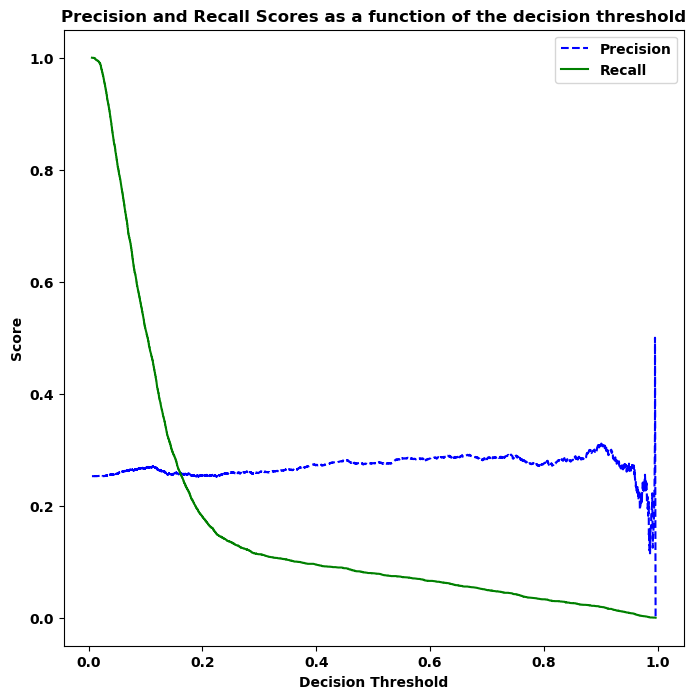

In [700]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [701]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.16141473

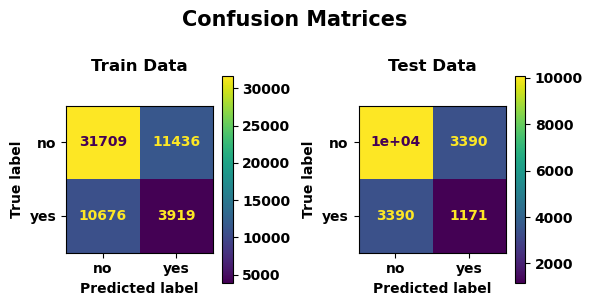

In [702]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_baseline >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_baseline >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [703]:
# scores on train data
print_report(y_train, train_predictions_baseline, thresh)

ROC AUC: 0.517
Balanced accuracy: 0.502
Accuracy: 0.617
Recall: 0.269
Average precision: 0.253
Specificity: 0.735
F1: 0.262
 


In [704]:
# scores on test data
print_report(y_test, test_predictions_baseline, thresh)

ROC AUC: 0.519
Balanced accuracy: 0.503
Accuracy: 0.624
Recall: 0.257
Average precision: 0.254
Specificity: 0.749
F1: 0.257
 


The threshold 0.02 predicts basically only crimes, hence we will disregard it.

The threshold 0.5 predicts almost no crimes, hence we will disregard it.

The threshold 0.10288311 yields the highest recall (0.504), f1 score (0.351), balanced accuracy (0.521), and average precision (0.261).

The threshold 0.16141473 yields the highest accuracy (0.624) and specificity (0.749).

## Model 2

Model 1 with class weights.

The goal is to identify crimes, but we don't have very many of those positive samples to work with, so we would want to have the classifier heavily weight the few examples that are available. We can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [705]:
pos = y_train.value_counts()[1]
neg = y_train.value_counts()[0]
total = pos + neg

In [706]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.67
Weight for class 1: 1.98


In [ ]:
# train a model with class weights
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(dict(X_train), y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping],
                                      validation_data=(dict(X_val), y_val), class_weight=class_weight)

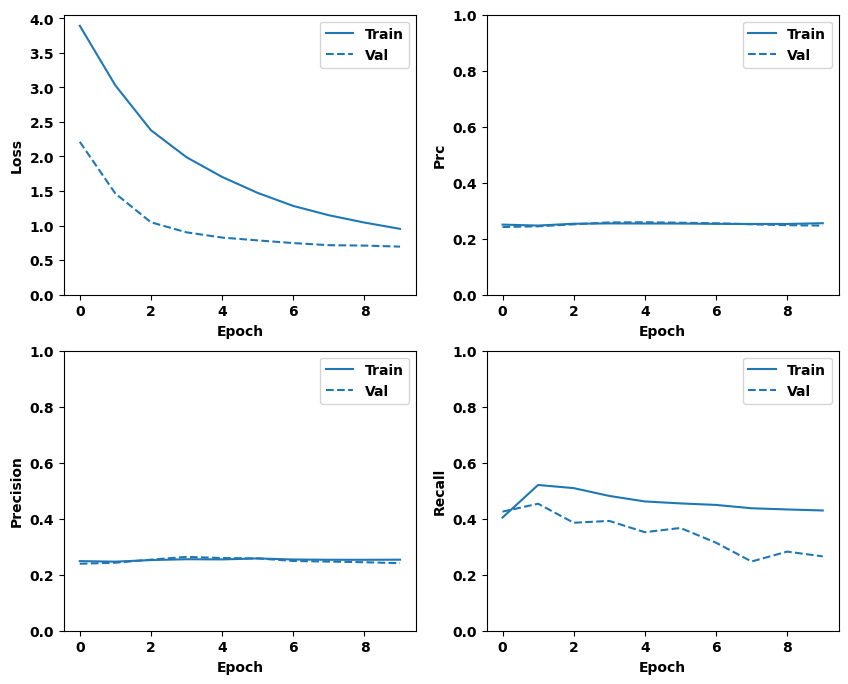

In [708]:
# training history
plt.figure(figsize=(10, 8))
plot_metrics(weighted_history)

In [709]:
# predict
train_predictions_weighted = weighted_model.predict(dict(X_train), batch_size=BATCH_SIZE).flatten()
test_predictions_weighted = weighted_model.predict(dict(X_test), batch_size=BATCH_SIZE).flatten()

9/9 [==============================] - 0s 3ms/step


In [710]:
# evaluate metrics
weighted_results = weighted_model.evaluate(dict(X_test), y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)

loss :  0.8195038437843323
tp :  1534.0
fp :  4460.0
tn :  9023.0
fn :  3027.0
accuracy :  0.5850698351860046
precision :  0.2559225857257843
recall :  0.33632975816726685
auc :  0.5111176371574402
prc :  0.25794708728790283


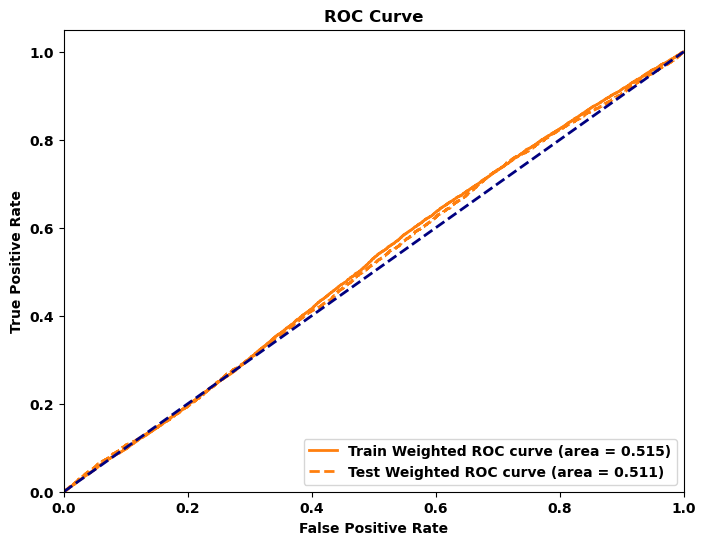

In [711]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test_weighted, tpr_test_weighted, _ = roc_curve(y_test, test_predictions_weighted)
roc_auc_test_weighted = auc(fpr_test_weighted, tpr_test_weighted)
fpr_train_weighted, tpr_train_weighted, _ = roc_curve(y_train, train_predictions_weighted)
roc_auc_train_weighted = auc(fpr_train_weighted, tpr_train_weighted)

plt.figure()
lw = 2
plt.plot(fpr_train_weighted, tpr_train_weighted, color=colors[1], lw=lw, label="Train Weighted ROC curve (area = %0.3f)" % roc_auc_train_weighted)
plt.plot(fpr_test_weighted, tpr_test_weighted, color=colors[1], linestyle='--', lw=lw, label="Test Weighted ROC curve (area = %0.3f)" % roc_auc_test_weighted)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [712]:
# standard threshold
thresh=0.5

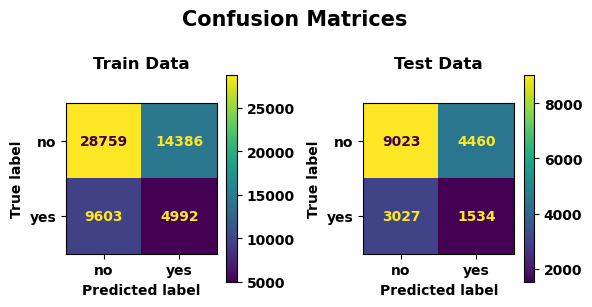

In [713]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_weighted >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_weighted >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [714]:
# scores on train data
print_report(y_train, train_predictions_weighted, thresh)

ROC AUC: 0.515
Balanced accuracy: 0.504
Accuracy: 0.585
Recall: 0.342
Average precision: 0.254
Specificity: 0.667
F1: 0.294
 


In [715]:
# scores on test data
print_report(y_test, test_predictions_weighted, thresh)

ROC AUC: 0.511
Balanced accuracy: 0.503
Accuracy: 0.585
Recall: 0.336
Average precision: 0.254
Specificity: 0.669
F1: 0.291
 


### Threshold Tuning, based on

#### F1 Score

In [716]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [717]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (test_predictions_weighted >= t).astype(int)) for t in thresholds]

In [718]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.041, F-score=0.404


In [719]:
# set threshold
thresh = thresholds[ix]
thresh

0.041

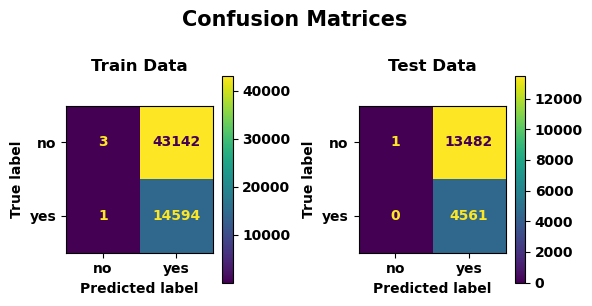

In [720]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_weighted >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_weighted >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [721]:
# scores on train data
print_report(y_train, train_predictions_weighted, thresh)

ROC AUC: 0.515
Balanced accuracy: 0.500
Accuracy: 0.253
Recall: 1.000
Average precision: 0.253
Specificity: 0.000
F1: 0.404
 


In [722]:
# scores on test data
print_report(y_test, test_predictions_weighted, thresh)

ROC AUC: 0.511
Balanced accuracy: 0.500
Accuracy: 0.253
Recall: 1.000
Average precision: 0.253
Specificity: 0.000
F1: 0.404
 


#### ROC AUC Curve

In [723]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_weighted)

In [724]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.355521


In [725]:
# set threshold
thresh = best_thresh
thresh

0.35552087

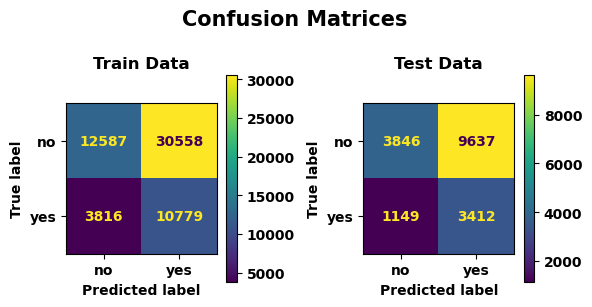

In [726]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_weighted >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_weighted >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [727]:
# scores on train data
print_report(y_train, train_predictions_weighted, thresh)

ROC AUC: 0.515
Balanced accuracy: 0.515
Accuracy: 0.405
Recall: 0.739
Average precision: 0.259
Specificity: 0.292
F1: 0.385
 


In [728]:
# scores on test data
print_report(y_test, test_predictions_weighted, thresh)

ROC AUC: 0.511
Balanced accuracy: 0.517
Accuracy: 0.402
Recall: 0.748
Average precision: 0.259
Specificity: 0.285
F1: 0.388
 


#### Precision-Recall Curve

In [729]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, test_predictions_weighted)

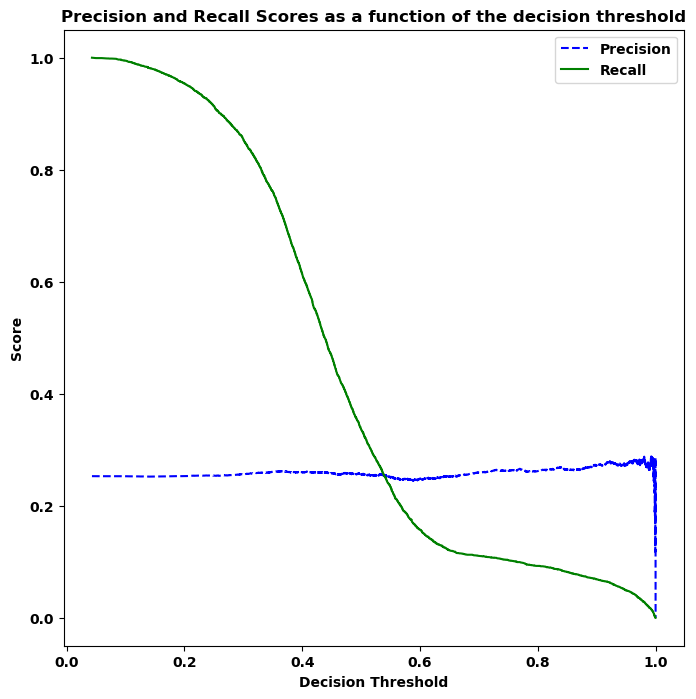

In [730]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [731]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.5390784

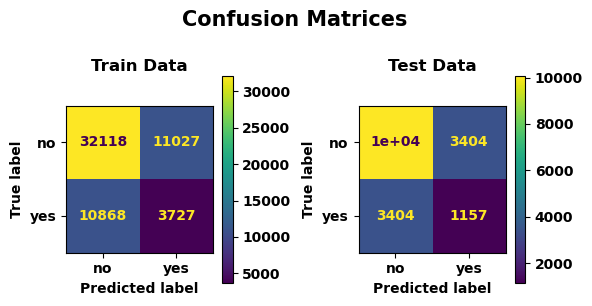

In [732]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_weighted >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_weighted >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [733]:
# scores on train data
print_report(y_train, train_predictions_weighted, thresh)

ROC AUC: 0.515
Balanced accuracy: 0.500
Accuracy: 0.621
Recall: 0.255
Average precision: 0.253
Specificity: 0.744
F1: 0.254
 


In [734]:
# scores on test data
print_report(y_test, test_predictions_weighted, thresh)

ROC AUC: 0.511
Balanced accuracy: 0.501
Accuracy: 0.623
Recall: 0.254
Average precision: 0.253
Specificity: 0.748
F1: 0.254
 


The threshold 0.04 predicts basically only crimes, hence we will disregard it.

The threshold 0.36 yields the highest recall (0.748), f1 score (0.388), balanced accuracy (0.517), and average precision (0.259).

The threshold 0.54 yields the highest accuracy (0.623) and specificity (0.748).

## Model 3

Model 1 with oversampling.

Resample the dataset by oversampling the minority class.

In [735]:
bool_train_labels = y_train != 0

pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [736]:
# get the right number of random indices from the positive examples

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features.iloc[choices]
res_pos_labels = pos_labels.iloc[choices]

res_pos_features.shape

(43145, 6)

In [737]:
# balance the dataset

resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(86290, 6)

In [738]:
# start with a positive and a negative dataset, and merge them

BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [739]:
# merge the two datasets
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [740]:
# mean value of the oversampled target
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.5068359375


To use this dataset, we'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [741]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

43.0

In [ ]:
# train on the oversampled data batch-wise
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((dict(X_val), y_val)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(resampled_ds, epochs=EPOCHS, steps_per_epoch=resampled_steps_per_epoch,
                                        callbacks=[early_stopping], validation_data=val_ds)

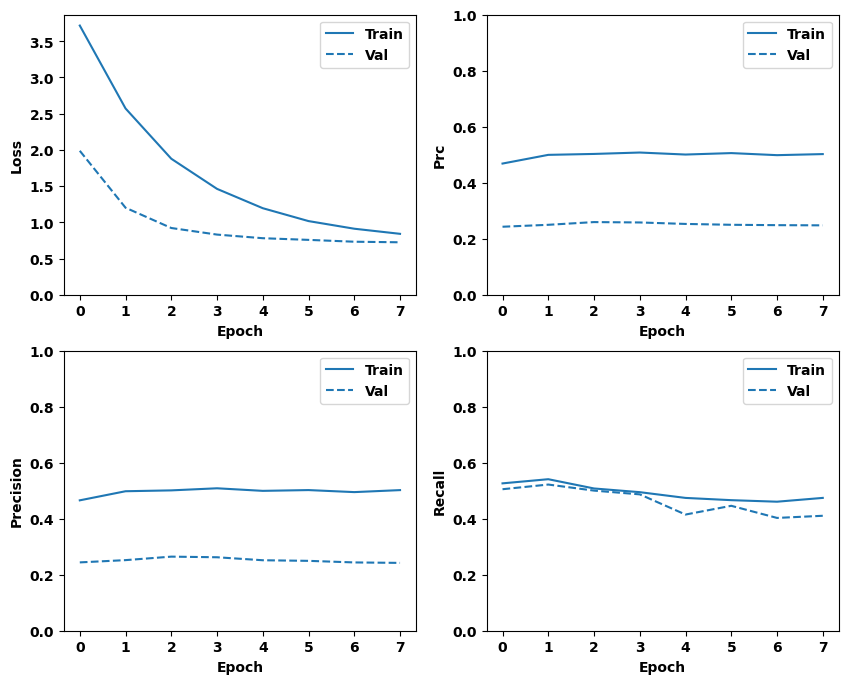

In [743]:
# training history
plt.figure(figsize=(10, 8))
plot_metrics(resampled_history)

In [ ]:
# re-train with breaking up the epochs
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((dict(X_val), y_val)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(resampled_ds, epochs=10*EPOCHS, steps_per_epoch=20,
                                        callbacks=[early_stopping], validation_data=val_ds)

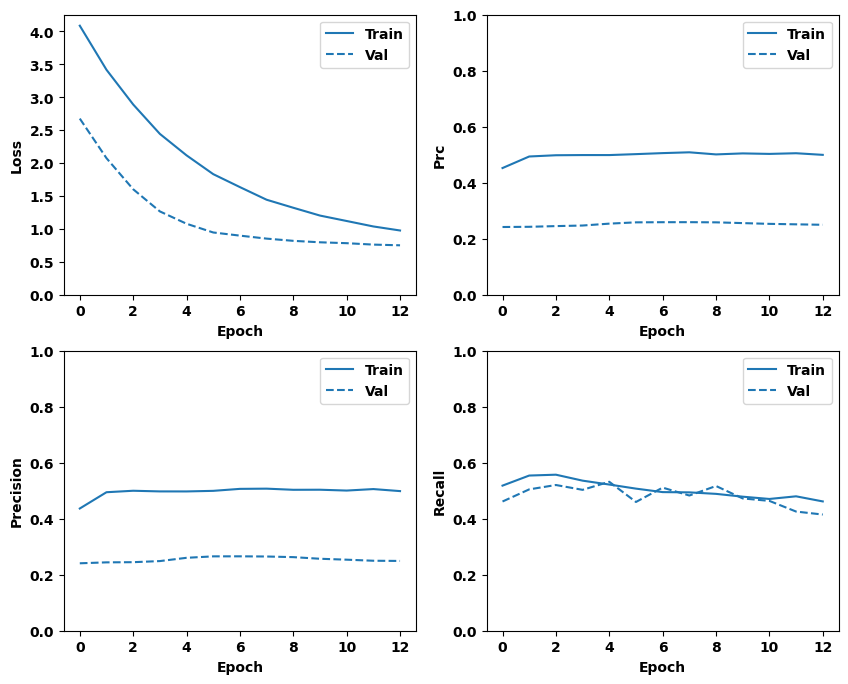

In [745]:
# training history
plt.figure(figsize=(10, 8))
plot_metrics(resampled_history)

In [746]:
# predict
train_predictions_resampled = resampled_model.predict(dict(X_train), batch_size=BATCH_SIZE).flatten()
test_predictions_resampled = resampled_model.predict(dict(X_test), batch_size=BATCH_SIZE).flatten()

9/9 [==============================] - 0s 3ms/step


In [747]:
# evaluate metrics
resampled_results = resampled_model.evaluate(dict(X_test), y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)

loss :  0.8442753553390503
tp :  2117.0
fp :  6031.0
tn :  7452.0
fn :  2444.0
accuracy :  0.5303148031234741
precision :  0.2598183751106262
recall :  0.46415260434150696
auc :  0.512241780757904
prc :  0.2591429650783539


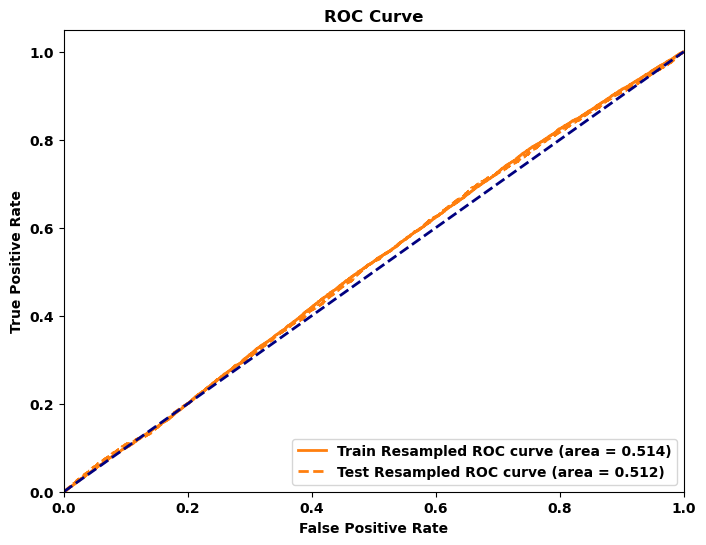

In [748]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test_resampled, tpr_test_resampled, _ = roc_curve(y_test, test_predictions_resampled)
roc_auc_test_resampled = auc(fpr_test_resampled, tpr_test_resampled)
fpr_train_resampled, tpr_train_resampled, _ = roc_curve(y_train, train_predictions_resampled)
roc_auc_train_resampled = auc(fpr_train_resampled, tpr_train_resampled)

plt.figure()
lw = 2
plt.plot(fpr_train_resampled, tpr_train_resampled, color=colors[1], lw=lw, label="Train Resampled ROC curve (area = %0.3f)" % roc_auc_train_resampled)
plt.plot(fpr_test_resampled, tpr_test_resampled, color=colors[1], linestyle='--', lw=lw, label="Test Resampled ROC curve (area = %0.3f)" % roc_auc_test_resampled)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [749]:
# standard threshold
thresh=0.5

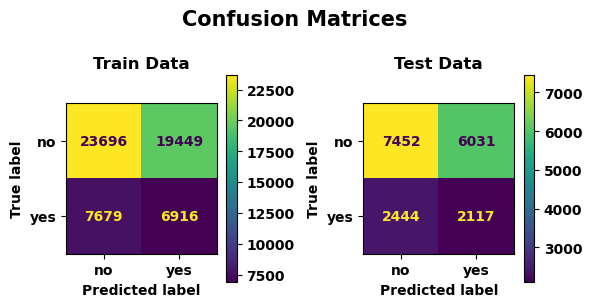

In [750]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_resampled >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_resampled >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [751]:
# scores on train data
print_report(y_train, train_predictions_resampled, thresh)

ROC AUC: 0.514
Balanced accuracy: 0.512
Accuracy: 0.530
Recall: 0.474
Average precision: 0.257
Specificity: 0.549
F1: 0.338
 


In [752]:
# scores on test data
print_report(y_test, test_predictions_resampled, thresh)

ROC AUC: 0.512
Balanced accuracy: 0.508
Accuracy: 0.530
Recall: 0.464
Average precision: 0.256
Specificity: 0.553
F1: 0.333
 


### Threshold Tuning, based on

#### F1 Score

In [753]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [754]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (test_predictions_resampled >= t).astype(int)) for t in thresholds]

In [755]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.092, F-score=0.404


In [756]:
# set threshold
thresh = thresholds[ix]
thresh

0.092

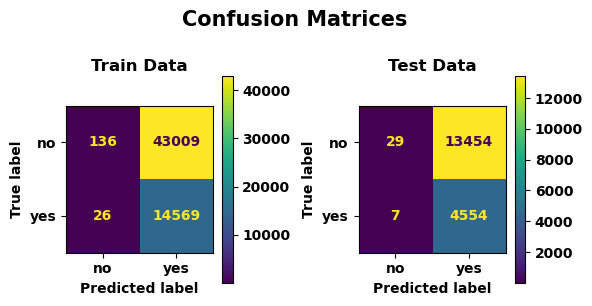

In [757]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_resampled >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_resampled >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [758]:
# scores on train data
print_report(y_train, train_predictions_resampled, thresh)

ROC AUC: 0.514
Balanced accuracy: 0.501
Accuracy: 0.255
Recall: 0.998
Average precision: 0.253
Specificity: 0.003
F1: 0.404
 


In [759]:
# scores on test data
print_report(y_test, test_predictions_resampled, thresh)

ROC AUC: 0.512
Balanced accuracy: 0.500
Accuracy: 0.254
Recall: 0.998
Average precision: 0.253
Specificity: 0.002
F1: 0.404
 


#### ROC AUC Curve

In [760]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_resampled)

In [761]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.437940


In [762]:
# set threshold
thresh = best_thresh
thresh

0.4379402

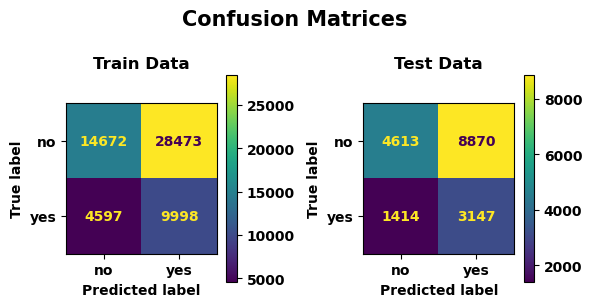

In [763]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_resampled >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_resampled >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [764]:
# scores on train data
print_report(y_train, train_predictions_resampled, thresh)

ROC AUC: 0.514
Balanced accuracy: 0.513
Accuracy: 0.427
Recall: 0.685
Average precision: 0.258
Specificity: 0.340
F1: 0.377
 


In [765]:
# scores on test data
print_report(y_test, test_predictions_resampled, thresh)

ROC AUC: 0.512
Balanced accuracy: 0.516
Accuracy: 0.430
Recall: 0.690
Average precision: 0.259
Specificity: 0.342
F1: 0.380
 


#### Precision-Recall Curve

In [766]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, test_predictions_resampled)

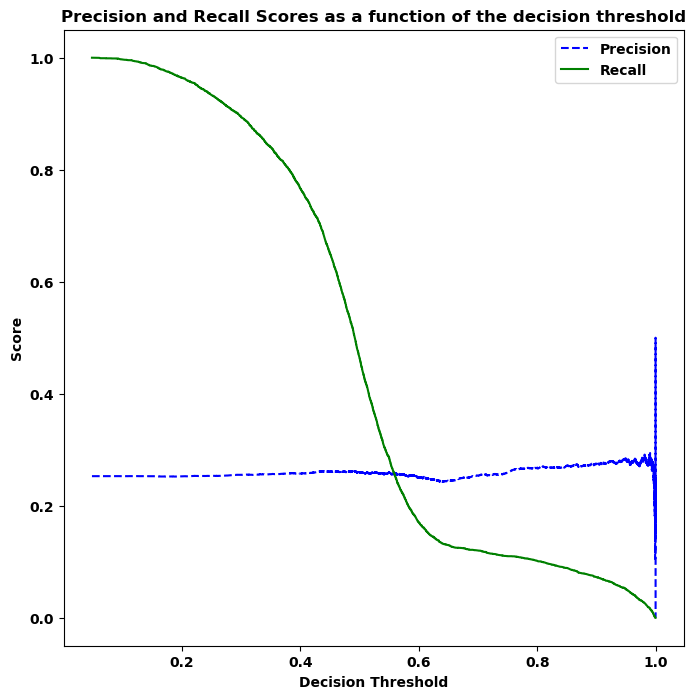

In [767]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [768]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.5585805

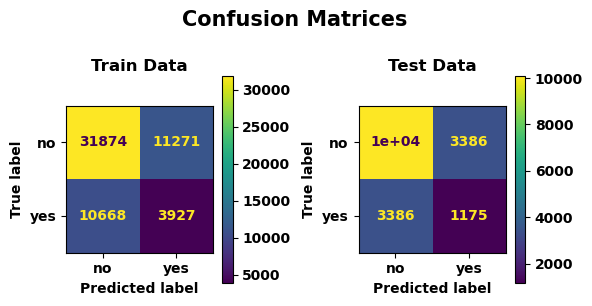

In [769]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_resampled >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_resampled >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [770]:
# scores on train data
print_report(y_train, train_predictions_resampled, thresh)

ROC AUC: 0.514
Balanced accuracy: 0.504
Accuracy: 0.620
Recall: 0.269
Average precision: 0.254
Specificity: 0.739
F1: 0.264
 


In [771]:
# scores on test data
print_report(y_test, test_predictions_resampled, thresh)

ROC AUC: 0.512
Balanced accuracy: 0.503
Accuracy: 0.625
Recall: 0.258
Average precision: 0.254
Specificity: 0.749
F1: 0.258
 


The threshold 0.09 basically predicts only crimes, hence we will disregard it.

The threshold 0.44 yields the highest recall (0.690), f1 score (0.380), balanced accuracy (0.516), and average precision (0.259).

The threshold 0.56 yields the highest accuracy (0.625) and specificity (0.749).

## Model 4

Use the data with the `part_of_day` feature, which increases the data size by a factor of four.

We apply a dense neural network with careful bias initialization.

In [244]:
# read data
crime_df_full = pd.read_csv('data/crime_df_classification.csv')
crime_df_full.head()

,dauid,neighbourhood,date,year,month,day,weekday,season,part_of_day,crime
0,59154181,Central Business District,2019-01-01,2019,1,1,Tuesday,winter,early morning,0
1,59154181,Central Business District,2019-01-02,2019,1,2,Wednesday,winter,early morning,0
2,59154181,Central Business District,2019-01-03,2019,1,3,Thursday,winter,early morning,0
3,59154181,Central Business District,2019-01-04,2019,1,4,Friday,winter,early morning,0
4,59154181,Central Business District,2019-01-05,2019,1,5,Saturday,winter,early morning,0


In [245]:
# data size
crime_df_full.shape

(4480464, 10)

In [246]:
# data types
crime_df_full.dtypes

dauid             int64
neighbourhood    object
date             object
year              int64
month             int64
day               int64
weekday          object
season           object
part_of_day      object
crime             int64
dtype: object

In [247]:
# convert date column to datetime type
crime_df_full['date'] = pd.to_datetime(crime_df_full['date'])
crime_df_full.dtypes

dauid                     int64
neighbourhood            object
date             datetime64[ns]
year                      int64
month                     int64
day                       int64
weekday                  object
season                   object
part_of_day              object
crime                     int64
dtype: object

In [248]:
# set target column
target_col = 'crime'

We model on a single neighbourhood. We choose the `Central Business District` as, we saw earlier, it has by far the highest amount of reported crimes.

In [249]:
# separate features and target
X = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'].drop(columns=[target_col,'date','neighbourhood'])
y = crime_df_full[crime_df_full['neighbourhood']=='Central Business District'][target_col]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 94, stratify = y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 94, stratify = y_train, test_size=0.2)

# print their shapes
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print('='*15)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(230963, 7)
(57741, 7)
(72176, 7)
(230963,)
(57741,)
(72176,)


In [251]:
# define variable types
CATEGORICAL_FEATURES = ['dauid', 'year', 'month', 'day']
STRING_CATEGORICAL_FEATURES = ['weekday','season','part_of_day']

In [252]:
# create a feature input layer
feature_layer_inputs = FeatureInputLayer({
    'dauid': tf.int64,
    'year': tf.int64,
    'month': tf.int64,
    'day': tf.int64,
    'weekday': tf.string,
    'season': tf.string,
    'part_of_day': tf.string
})

# implement a similar preprocessing pipeline to sklearn
preprocessor = FeatureUnion(
    feature_preprocessor_list = [
        ('cat', IntegerLookup(), CATEGORICAL_FEATURES),
        ('str_cat', StringLookup(), STRING_CATEGORICAL_FEATURES)
    ]
)

# update the preprocessing layer states
preprocessor.adapt(X_train)

In [299]:
## taken from [6] and slightly modified

# define the model and metrics:
# a simple neural network with a densly connected hidden layer, 
# a dropout layer to reduce overfitting, 
# and an output sigmoid layer that returns the probability of crime

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias='zeros', inputs=feature_layer_inputs):
    if output_bias!='zeros':
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    preprocessed_inputs = preprocessor(inputs)
    x = layers.Dense(20, activation="relu")(preprocessed_inputs)
    x = layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
    model = tf.keras.Model(inputs=feature_layer_inputs, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return model

In [300]:
# build the model
EPOCHS = 300
BATCH_SIZE = 2048
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

model = make_model()
model.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dauid (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 day (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 month (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 part_of_day (InputLayer)       [(None, 1)]          0           []                               
                                                                                           

In [301]:
# test run the model
model.predict(dict(X_train[:10]))

1/1 [==============================] - 0s 106ms/step


array([[0.99919766],
       [0.9496752 ],
       [0.9997454 ],
       [0.99961925],
       [0.9972434 ],
       [0.9970729 ],
       [0.98934144],
       [0.99687415],
       [0.90601355],
       [0.9889633 ]], dtype=float32)

In [302]:
# compute loss
results = model.evaluate(dict(X_train), y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 5.7879


### Set the correct initial bias

Our dataset is imbalanced, so we should set the output layer's bias to reflect that. This can help with initial convergence.

The correct bias should be:

In [303]:
initial_bias = np.log([y_train.value_counts()[1]/y_train.value_counts()[0]])
initial_bias

array([-2.35704579])

If we set that as the initial bias, the model should give more reasonable initial guesses.

In [304]:
# test run the model
model = make_model(output_bias=initial_bias)
model.predict(dict(X_train[:10]))

1/1 [==============================] - 0s 82ms/step


array([[1.8203822e-08],
       [4.8199235e-04],
       [6.2232992e-08],
       [1.5949522e-06],
       [3.6936638e-09],
       [1.9217080e-06],
       [7.5344008e-07],
       [7.4907541e-07],
       [4.4238414e-03],
       [2.1011194e-06]], dtype=float32)

In [305]:
# compute loss
results = model.evaluate(dict(X_train), y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.2404


In [306]:
# checkpoint the initial weights
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses:

In [307]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(dict(X_train), y_train, batch_size=BATCH_SIZE, epochs=20,
                              validation_data=(dict(X_val), y_val), verbose=0)

In [308]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(dict(X_train), y_train, batch_size=BATCH_SIZE, epochs=20,
                              validation_data=(dict(X_val), y_val), verbose=0)

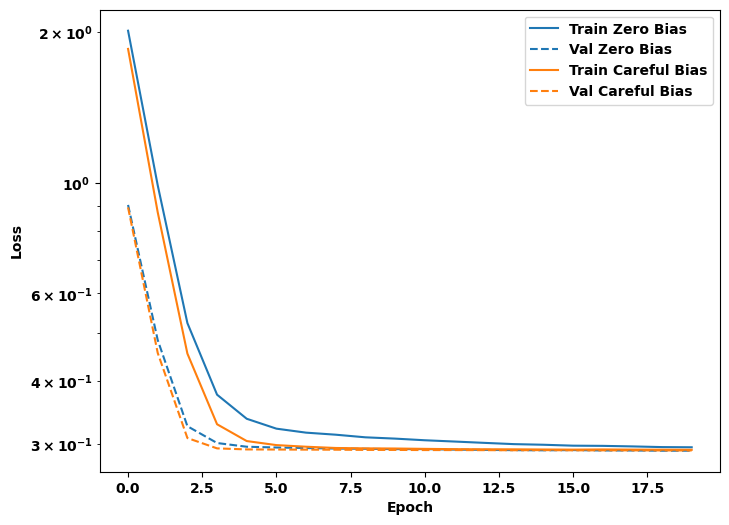

In [309]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The careful initialization gives a slight advantage.

### Train the model

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(dict(X_train), y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                             callbacks=[early_stopping], validation_data=(dict(X_val), y_val))

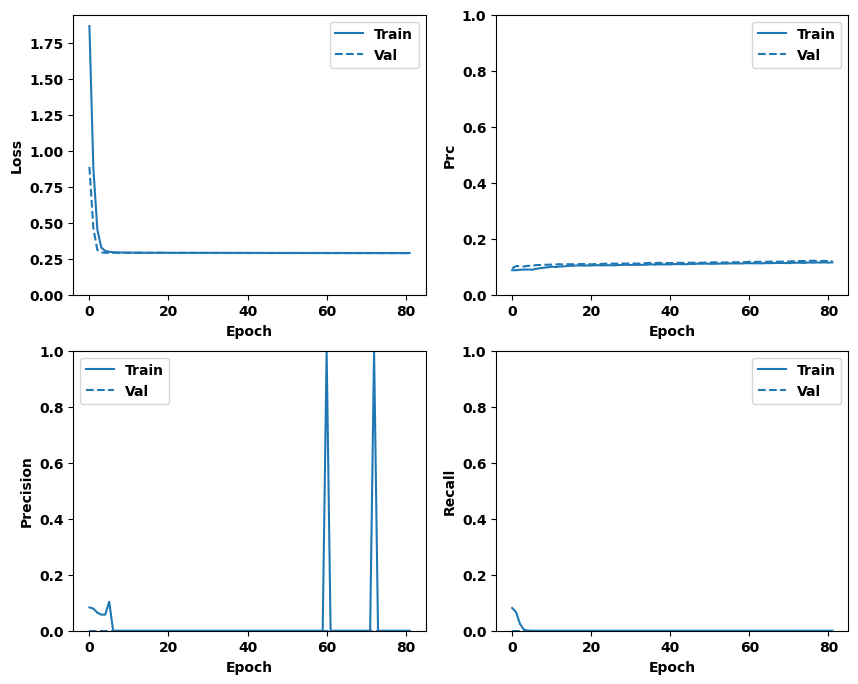

In [311]:
# training history
plt.figure(figsize=(10, 8))
plot_metrics(baseline_history)

In [312]:
# predict
train_predictions_baseline = model.predict(dict(X_train), batch_size=BATCH_SIZE).flatten()
test_predictions_baseline = model.predict(dict(X_test), batch_size=BATCH_SIZE).flatten()

36/36 [==============================] - 0s 4ms/step


In [313]:
# evaluate metrics
baseline_results = model.evaluate(dict(X_test), y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

loss :  0.28946271538734436
tp :  0.0
fp :  0.0
tn :  65932.0
fn :  6244.0
accuracy :  0.9134892225265503
precision :  0.0
recall :  0.0
auc :  0.602057158946991
prc :  0.11591305583715439


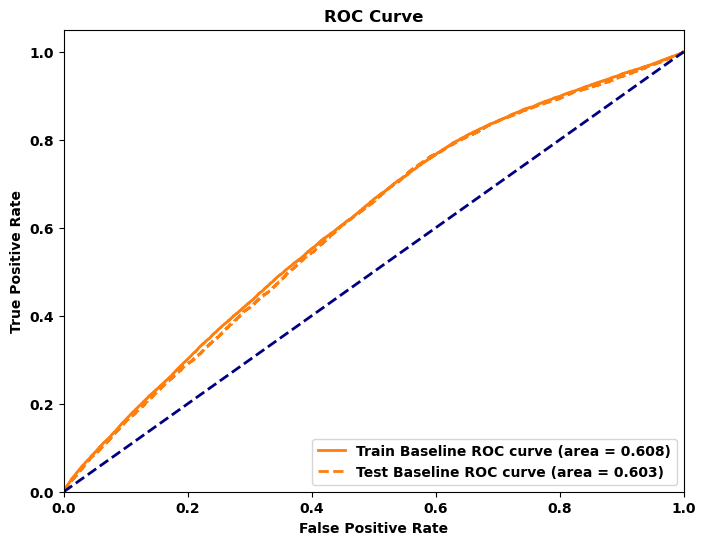

In [314]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test_baseline, tpr_test_baseline, _ = roc_curve(y_test, test_predictions_baseline)
roc_auc_test_baseline = auc(fpr_test_baseline, tpr_test_baseline)
fpr_train_baseline, tpr_train_baseline, _ = roc_curve(y_train, train_predictions_baseline)
roc_auc_train_baseline = auc(fpr_train_baseline, tpr_train_baseline)

plt.figure()
lw = 2
plt.plot(fpr_train_baseline, tpr_train_baseline, color=colors[1], lw=lw, label="Train Baseline ROC curve (area = %0.3f)" % roc_auc_train_baseline)
plt.plot(fpr_test_baseline, tpr_test_baseline, color=colors[1], linestyle='--', lw=lw, label="Test Baseline ROC curve (area = %0.3f)" % roc_auc_test_baseline)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [315]:
# standard threshold
thresh=0.5

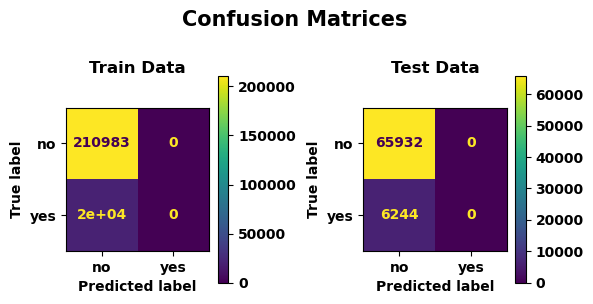

In [316]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_baseline >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_baseline >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [317]:
# scores on train data
print_report(y_train, train_predictions_baseline, thresh)

ROC AUC: 0.608
Balanced accuracy: 0.500
Accuracy: 0.913
Recall: 0.000
Average precision: 0.087
Specificity: 1.000
F1: 0.000
 


In [318]:
# scores on test data
print_report(y_test, test_predictions_baseline, thresh)

ROC AUC: 0.603
Balanced accuracy: 0.500
Accuracy: 0.913
Recall: 0.000
Average precision: 0.087
Specificity: 1.000
F1: 0.000
 


### Threshold Tuning, based on

#### F1 Score

In [319]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [320]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (test_predictions_baseline >= t).astype(int)) for t in thresholds]

In [321]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.090, F-score=0.191


In [322]:
# set threshold
thresh = thresholds[ix]
thresh

0.09

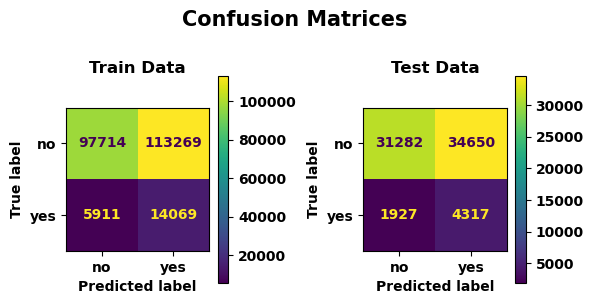

In [323]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_baseline >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_baseline >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [324]:
# scores on train data
print_report(y_train, train_predictions_baseline, thresh)

ROC AUC: 0.608
Balanced accuracy: 0.584
Accuracy: 0.484
Recall: 0.704
Average precision: 0.103
Specificity: 0.463
F1: 0.191
 


In [325]:
# scores on test data
print_report(y_test, test_predictions_baseline, thresh)

ROC AUC: 0.603
Balanced accuracy: 0.583
Accuracy: 0.493
Recall: 0.691
Average precision: 0.103
Specificity: 0.474
F1: 0.191
 


#### ROC AUC Curve

In [326]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_baseline)

In [327]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.087529


In [328]:
# set threshold
thresh = best_thresh
thresh

0.087528564

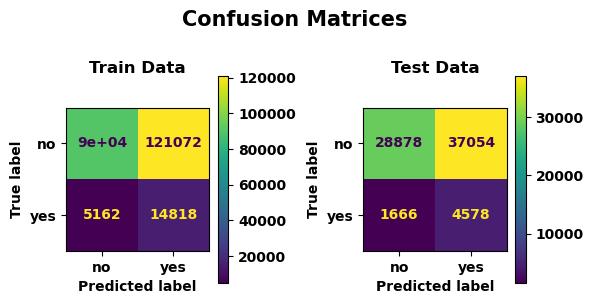

In [329]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_baseline >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_baseline >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [330]:
# scores on train data
print_report(y_train, train_predictions_baseline, thresh)

ROC AUC: 0.608
Balanced accuracy: 0.584
Accuracy: 0.453
Recall: 0.742
Average precision: 0.103
Specificity: 0.426
F1: 0.190
 


In [331]:
# scores on test data
print_report(y_test, test_predictions_baseline, thresh)

ROC AUC: 0.603
Balanced accuracy: 0.586
Accuracy: 0.464
Recall: 0.733
Average precision: 0.104
Specificity: 0.438
F1: 0.191
 


#### Precision-Recall Curve

In [332]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, test_predictions_baseline)

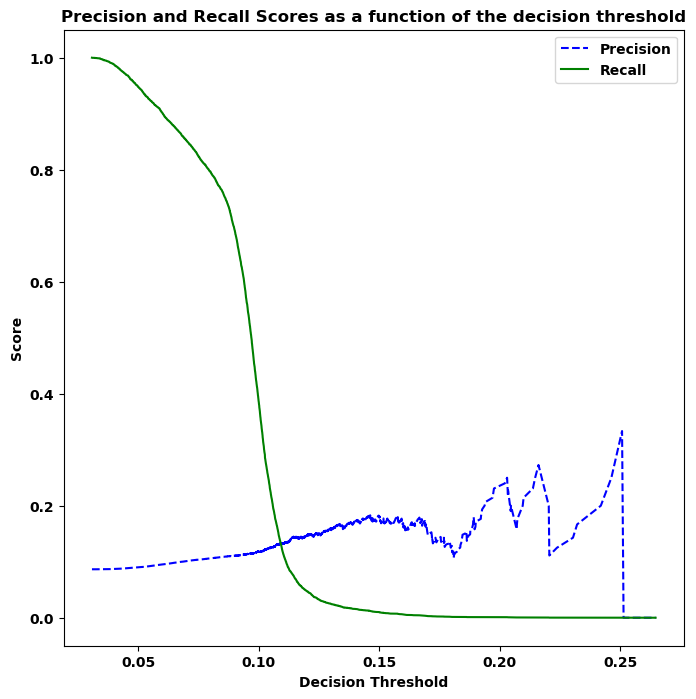

In [333]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [334]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.10905077

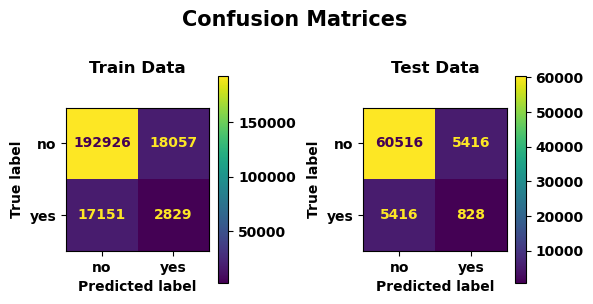

In [335]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_baseline >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_baseline >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [336]:
# scores on train data
print_report(y_train, train_predictions_baseline, thresh)

ROC AUC: 0.608
Balanced accuracy: 0.528
Accuracy: 0.848
Recall: 0.142
Average precision: 0.093
Specificity: 0.914
F1: 0.138
 


In [337]:
# scores on test data
print_report(y_test, test_predictions_baseline, thresh)

ROC AUC: 0.603
Balanced accuracy: 0.525
Accuracy: 0.850
Recall: 0.133
Average precision: 0.093
Specificity: 0.918
F1: 0.133
 


The model with the default threshold 0.5 can't predict crimes, hence we will disregard it.

The threshold 0.0875 yields the highest recall (0.733), f1 score (0.191), balanced accuracy (0.586), and average precision (0.104).

The threshold 0.11 yields the highest accuracy (0.850) and specificity (0.918).

## Model 5

Model 4 with class weights.

The goal is to identify crimes, but we don't have very many of those positive samples to work with, so we would want to have the classifier heavily weight the few examples that are available. We can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [338]:
pos = y_train.value_counts()[1]
neg = y_train.value_counts()[0]
total = pos + neg

In [339]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.78


In [ ]:
# train a model with class weights
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(dict(X_train), y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping],
                                      validation_data=(dict(X_val), y_val), class_weight=class_weight)

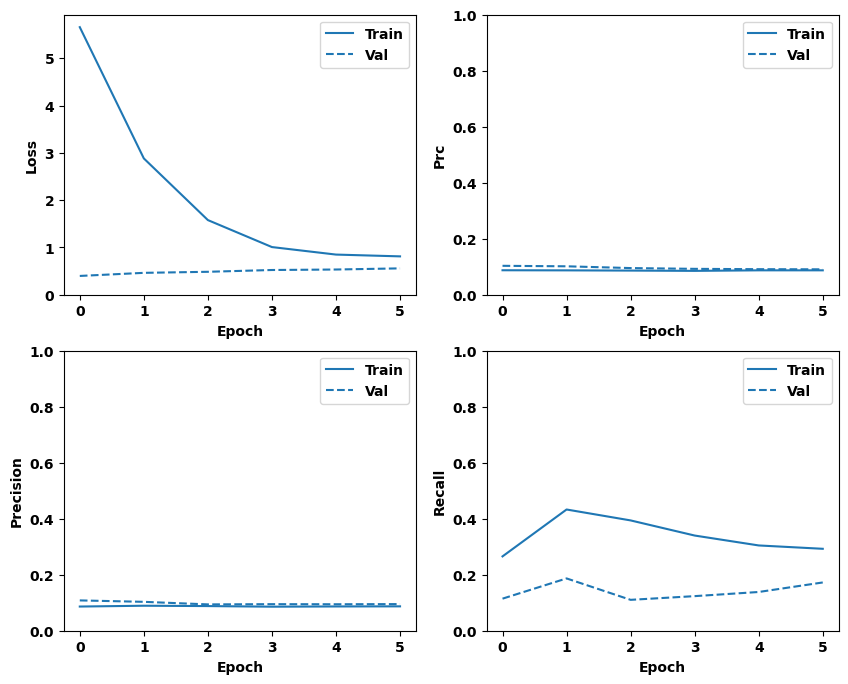

In [341]:
# training history
plt.figure(figsize=(10, 8))
plot_metrics(weighted_history)

In [342]:
# predict
train_predictions_weighted = weighted_model.predict(dict(X_train), batch_size=BATCH_SIZE).flatten()
test_predictions_weighted = weighted_model.predict(dict(X_test), batch_size=BATCH_SIZE).flatten()

36/36 [==============================] - 0s 5ms/step


In [343]:
# evaluate metrics
weighted_results = weighted_model.evaluate(dict(X_test), y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)

loss :  0.39441102743148804
tp :  731.0
fp :  5543.0
tn :  60389.0
fn :  5513.0
accuracy :  0.8468188643455505
precision :  0.11651258915662766
recall :  0.11707238852977753
auc :  0.5701003670692444
prc :  0.10407130420207977


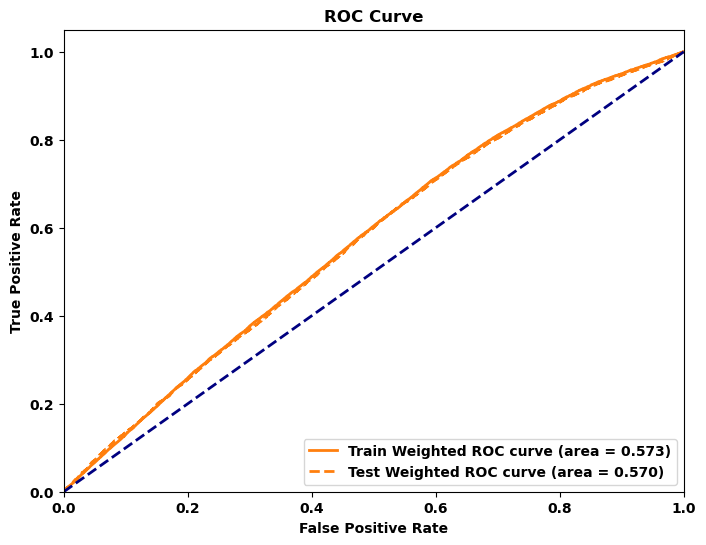

In [344]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test_weighted, tpr_test_weighted, _ = roc_curve(y_test, test_predictions_weighted)
roc_auc_test_weighted = auc(fpr_test_weighted, tpr_test_weighted)
fpr_train_weighted, tpr_train_weighted, _ = roc_curve(y_train, train_predictions_weighted)
roc_auc_train_weighted = auc(fpr_train_weighted, tpr_train_weighted)

plt.figure()
lw = 2
plt.plot(fpr_train_weighted, tpr_train_weighted, color=colors[1], lw=lw, label="Train Weighted ROC curve (area = %0.3f)" % roc_auc_train_weighted)
plt.plot(fpr_test_weighted, tpr_test_weighted, color=colors[1], linestyle='--', lw=lw, label="Test Weighted ROC curve (area = %0.3f)" % roc_auc_test_weighted)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [345]:
# standard threshold
thresh=0.5

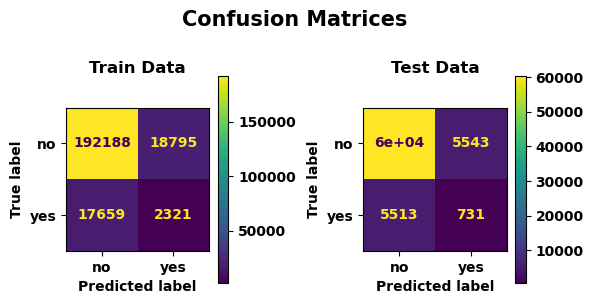

In [346]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_weighted >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_weighted >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [347]:
# scores on train data
print_report(y_train, train_predictions_weighted, thresh)

ROC AUC: 0.573
Balanced accuracy: 0.514
Accuracy: 0.842
Recall: 0.116
Average precision: 0.089
Specificity: 0.911
F1: 0.113
 


In [348]:
# scores on test data
print_report(y_test, test_predictions_weighted, thresh)

ROC AUC: 0.570
Balanced accuracy: 0.517
Accuracy: 0.847
Recall: 0.117
Average precision: 0.090
Specificity: 0.916
F1: 0.117
 


### Threshold Tuning, based on

#### F1 Score

In [349]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [350]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (test_predictions_weighted >= t).astype(int)) for t in thresholds]

In [351]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.049, F-score=0.177


In [352]:
# set threshold
thresh = thresholds[ix]
thresh

0.049

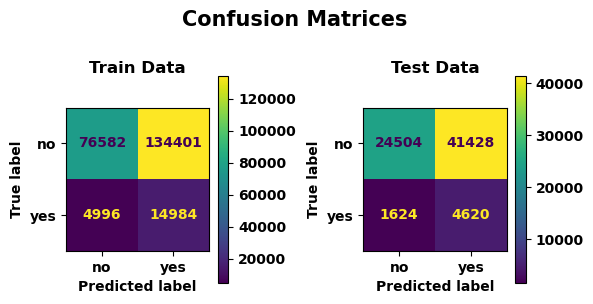

In [353]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_weighted >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_weighted >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [354]:
# scores on train data
print_report(y_train, train_predictions_weighted, thresh)

ROC AUC: 0.573
Balanced accuracy: 0.556
Accuracy: 0.396
Recall: 0.750
Average precision: 0.097
Specificity: 0.363
F1: 0.177
 


In [355]:
# scores on test data
print_report(y_test, test_predictions_weighted, thresh)

ROC AUC: 0.570
Balanced accuracy: 0.556
Accuracy: 0.404
Recall: 0.740
Average precision: 0.097
Specificity: 0.372
F1: 0.177
 


#### ROC AUC Curve

In [356]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_weighted)

In [357]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.048983


In [358]:
# set threshold
thresh = best_thresh
thresh

0.048982684

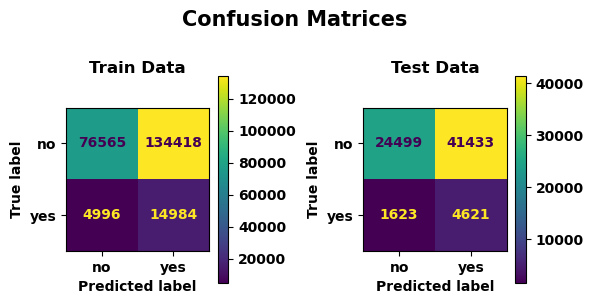

In [359]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_weighted >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_weighted >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [360]:
# scores on train data
print_report(y_train, train_predictions_weighted, thresh)

ROC AUC: 0.573
Balanced accuracy: 0.556
Accuracy: 0.396
Recall: 0.750
Average precision: 0.097
Specificity: 0.363
F1: 0.177
 


In [361]:
# scores on test data
print_report(y_test, test_predictions_weighted, thresh)

ROC AUC: 0.570
Balanced accuracy: 0.556
Accuracy: 0.403
Recall: 0.740
Average precision: 0.097
Specificity: 0.372
F1: 0.177
 


#### Precision-Recall Curve

In [362]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, test_predictions_weighted)

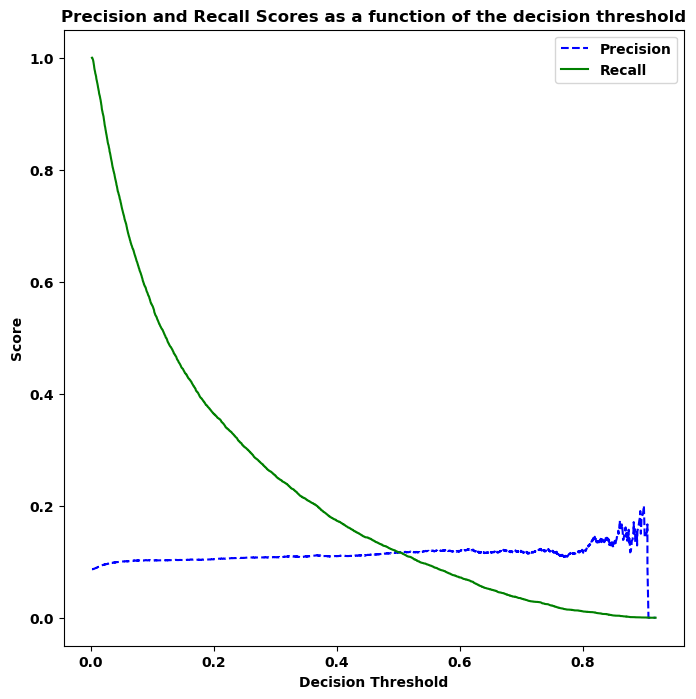

In [363]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [368]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.50120294

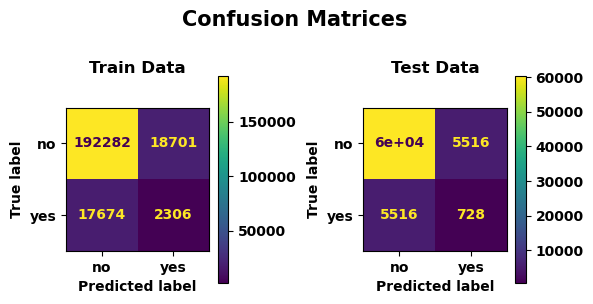

In [369]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_weighted >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_weighted >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [370]:
# scores on train data
print_report(y_train, train_predictions_weighted, thresh)

ROC AUC: 0.573
Balanced accuracy: 0.513
Accuracy: 0.843
Recall: 0.115
Average precision: 0.089
Specificity: 0.911
F1: 0.113
 


In [371]:
# scores on test data
print_report(y_test, test_predictions_weighted, thresh)

ROC AUC: 0.570
Balanced accuracy: 0.516
Accuracy: 0.847
Recall: 0.117
Average precision: 0.090
Specificity: 0.916
F1: 0.117
 


The threshold 0.05 yields the highest recall (0.740), f1 score (0.177), balanced accuracy (0.556), and average precision (0.097).

The threshold 0.5 yields the highest accuracy (0.847) and specificity (0.916).

## Model 6

Model 4 with oversampling.

Resample the dataset by oversampling the minority class.

In [372]:
bool_train_labels = y_train != 0

pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [373]:
# get the right number of random indices from the positive examples

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features.iloc[choices]
res_pos_labels = pos_labels.iloc[choices]

res_pos_features.shape

(210983, 7)

In [374]:
# balance the dataset

resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(421966, 7)

In [375]:
# start with a positive and a negative dataset, and merge them

BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [376]:
# merge the two datasets
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [377]:
# mean value of the oversampled target
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.49267578125


To use this dataset, we'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [378]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

207.0

In [ ]:
# train on the oversampled data batch-wise
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((dict(X_val), y_val)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(resampled_ds, epochs=EPOCHS, steps_per_epoch=resampled_steps_per_epoch,
                                        callbacks=[early_stopping], validation_data=val_ds)

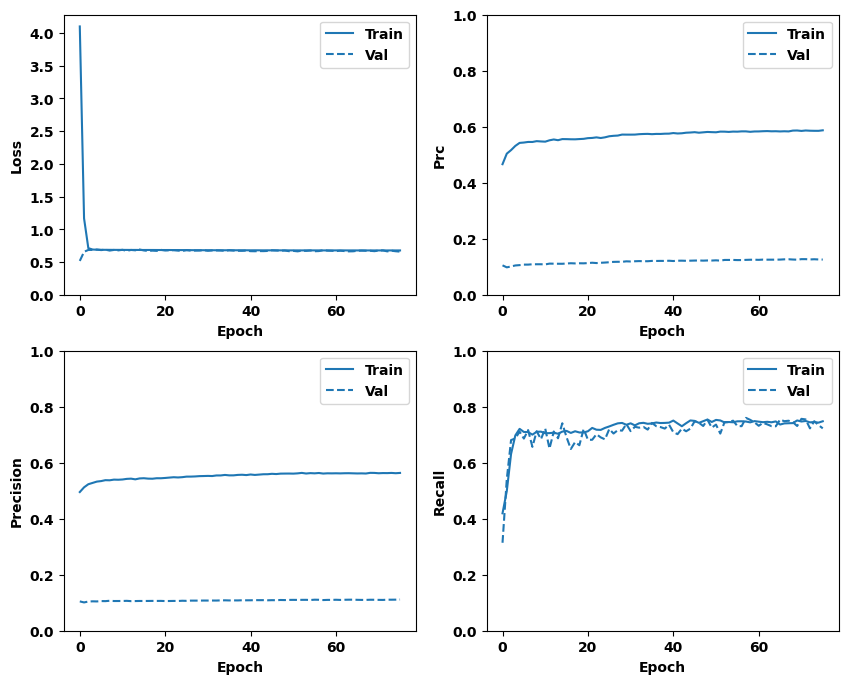

In [380]:
# training history
plt.figure(figsize=(10, 8))
plot_metrics(resampled_history)

In [ ]:
# re-train with breaking up the epochs
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((dict(X_val), y_val)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(resampled_ds, epochs=10*EPOCHS, steps_per_epoch=100,
                                        callbacks=[early_stopping], validation_data=val_ds)

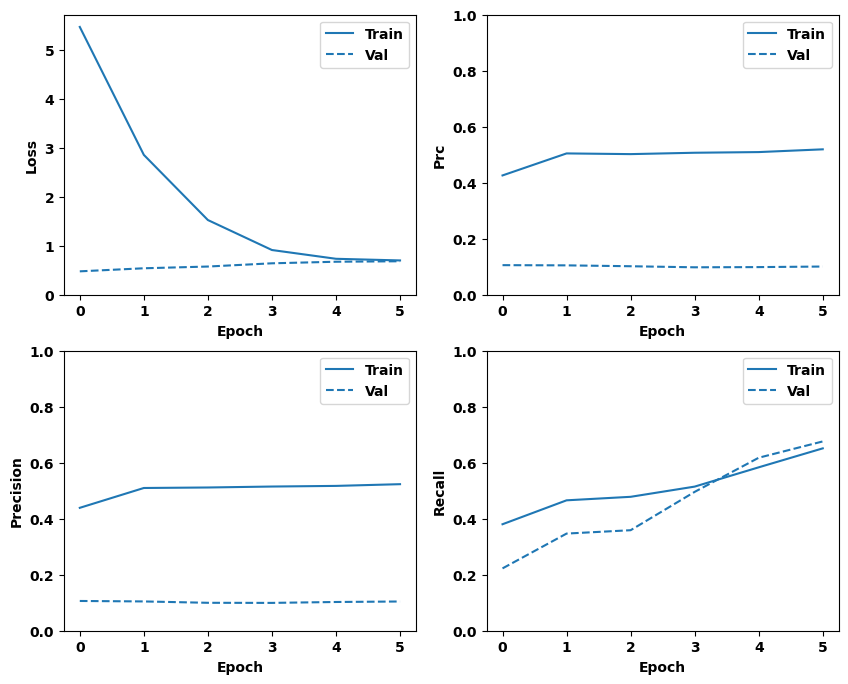

In [384]:
# training history
plt.figure(figsize=(10, 8))
plot_metrics(resampled_history)

In [385]:
# predict
train_predictions_resampled = resampled_model.predict(dict(X_train), batch_size=BATCH_SIZE).flatten()
test_predictions_resampled = resampled_model.predict(dict(X_test), batch_size=BATCH_SIZE).flatten()

36/36 [==============================] - 0s 5ms/step


In [386]:
# evaluate metrics
resampled_results = resampled_model.evaluate(dict(X_test), y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)

loss :  0.47416698932647705
tp :  1366.0
fp :  11358.0
tn :  54574.0
fn :  4878.0
accuracy :  0.7750498652458191
precision :  0.10735617578029633
recall :  0.21877001225948334
auc :  0.5767266750335693
prc :  0.1053604856133461


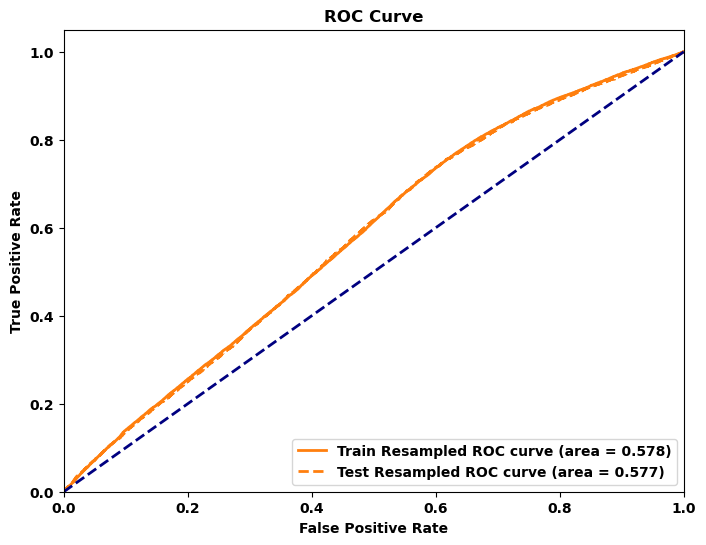

In [387]:
# compute and plot Receiver operating characteristic (ROC) curve for train and test data

fpr_test_resampled, tpr_test_resampled, _ = roc_curve(y_test, test_predictions_resampled)
roc_auc_test_resampled = auc(fpr_test_resampled, tpr_test_resampled)
fpr_train_resampled, tpr_train_resampled, _ = roc_curve(y_train, train_predictions_resampled)
roc_auc_train_resampled = auc(fpr_train_resampled, tpr_train_resampled)

plt.figure()
lw = 2
plt.plot(fpr_train_resampled, tpr_train_resampled, color=colors[1], lw=lw, label="Train Resampled ROC curve (area = %0.3f)" % roc_auc_train_resampled)
plt.plot(fpr_test_resampled, tpr_test_resampled, color=colors[1], linestyle='--', lw=lw, label="Test Resampled ROC curve (area = %0.3f)" % roc_auc_test_resampled)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [388]:
# standard threshold
thresh=0.5

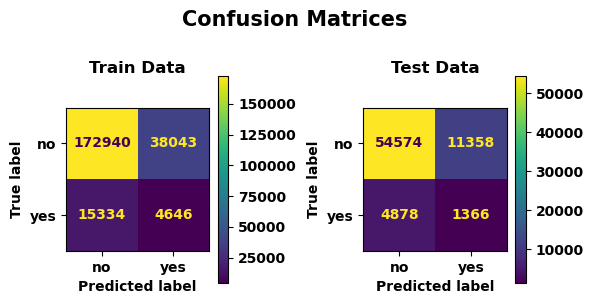

In [389]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_resampled >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_resampled >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [390]:
# scores on train data
print_report(y_train, train_predictions_resampled, thresh)

ROC AUC: 0.578
Balanced accuracy: 0.526
Accuracy: 0.769
Recall: 0.233
Average precision: 0.092
Specificity: 0.820
F1: 0.148
 


In [391]:
# scores on test data
print_report(y_test, test_predictions_resampled, thresh)

ROC AUC: 0.577
Balanced accuracy: 0.523
Accuracy: 0.775
Recall: 0.219
Average precision: 0.091
Specificity: 0.828
F1: 0.144
 


### Threshold Tuning, based on

#### F1 Score

In [392]:
# define the thresholds
thresholds = np.arange(0,1,0.001)

In [393]:
# evalaute the thresholds
# apply the thresholds to the positive class probabilities and create labels
scores = [f1_score(y_test, (test_predictions_resampled >= t).astype(int)) for t in thresholds]

In [394]:
# get the best threshold
ix = np.argmax(scores)
print("Threshold = %.3f, F-score=%.3f" %(thresholds[ix], scores[ix]))

Threshold = 0.065, F-score=0.183


In [395]:
# set threshold
thresh = thresholds[ix]
thresh

0.065

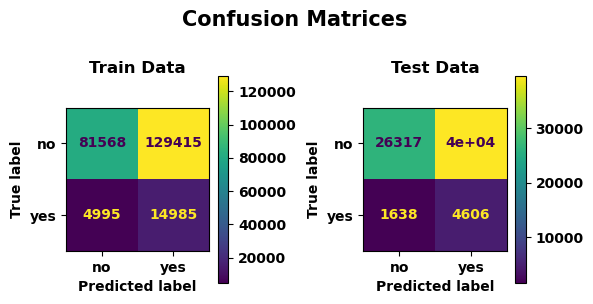

In [396]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_resampled >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_resampled >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [397]:
# scores on train data
print_report(y_train, train_predictions_resampled, thresh)

ROC AUC: 0.578
Balanced accuracy: 0.568
Accuracy: 0.418
Recall: 0.750
Average precision: 0.099
Specificity: 0.387
F1: 0.182
 


In [398]:
# scores on test data
print_report(y_test, test_predictions_resampled, thresh)

ROC AUC: 0.577
Balanced accuracy: 0.568
Accuracy: 0.428
Recall: 0.738
Average precision: 0.100
Specificity: 0.399
F1: 0.183
 


#### ROC AUC Curve

In [399]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_resampled)

In [400]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print("Best threshold = %f" %best_thresh)

Best threshold = 0.059948


In [401]:
# set threshold
thresh = best_thresh
thresh

0.05994768

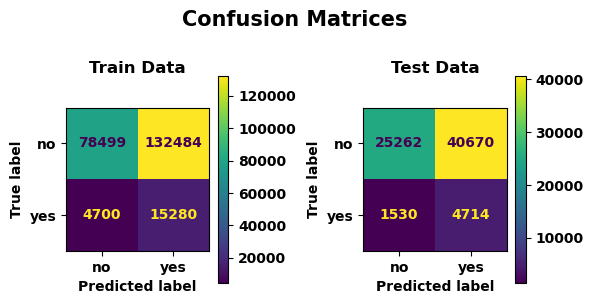

In [402]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_resampled >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_resampled >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [403]:
# scores on train data
print_report(y_train, train_predictions_resampled, thresh)

ROC AUC: 0.578
Balanced accuracy: 0.568
Accuracy: 0.406
Recall: 0.765
Average precision: 0.099
Specificity: 0.372
F1: 0.182
 


In [404]:
# scores on test data
print_report(y_test, test_predictions_resampled, thresh)

ROC AUC: 0.577
Balanced accuracy: 0.569
Accuracy: 0.415
Recall: 0.755
Average precision: 0.100
Specificity: 0.383
F1: 0.183
 


#### Precision-Recall Curve

In [405]:
# precision-recall pairs for different probability thresholds
p, r, thresholds = precision_recall_curve(y_test, test_predictions_resampled)

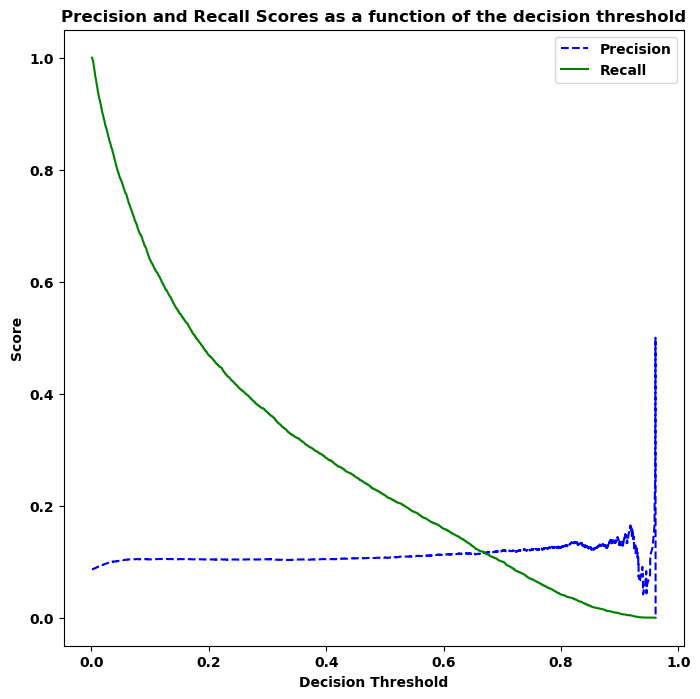

In [406]:
# plot precision-recall curve
plot_precision_recall_vs_threshold(p, r, thresholds)

In [407]:
# best threshold
thresh = thresholds[np.argmin(np.abs(p-r))]
thresh

0.669977

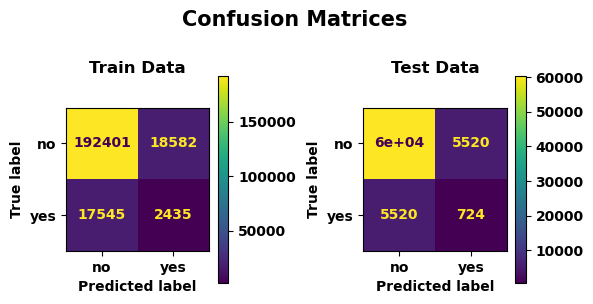

In [408]:
# confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('Confusion Matrices', fontsize=15, y=1.)

# confusion matrix on train data
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, (train_predictions_resampled >= thresh)), 
                                          display_labels = np.array(['no','yes']))

cm_display_train.plot(ax=ax[0])
ax[0].set_title('Train Data', pad=25)

# confusion matrix on test data
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, (test_predictions_resampled >= thresh)), 
                                         display_labels = np.array(['no','yes']))
    
cm_display_test.plot(ax=ax[1])
ax[1].set_title('Test Data', pad=25)
    
fig.tight_layout()

In [409]:
# scores on train data
print_report(y_train, train_predictions_resampled, thresh)

ROC AUC: 0.578
Balanced accuracy: 0.517
Accuracy: 0.844
Recall: 0.122
Average precision: 0.090
Specificity: 0.912
F1: 0.119
 


In [410]:
# scores on test data
print_report(y_test, test_predictions_resampled, thresh)

ROC AUC: 0.577
Balanced accuracy: 0.516
Accuracy: 0.847
Recall: 0.116
Average precision: 0.090
Specificity: 0.916
F1: 0.116
 


The threshold 0.06 yields the highest recall (0.755), f1 score (0.183), balanced accuracy (0.569), and average precision (0.100).

The threshold 0.67 yields the highest accuracy (0.847) and specificity (0.916).

## Results

- We choose to predict crime in the `Central Business District` as it has by far the highest amount of reported crimes.


- We compared dense neural networks on six different models:
    1. Data without the `part_of_day` feature.
    2. Data without the `part_of_day` feature and class weights.
    3. Data without the `part_of_day` feature and oversampling.
    4. Data with the `part_of_day` feature.
    5. Data with the `part_of_day` feature and class weights.
    6. Data with the `part_of_day` feature and oversampling.
    

- Model 1 is the best model with the following regard:
    - The threshold 0.10 yields the highest average precision (0.261).
    
    
- Model 2 is the best model with the following regard:
    - The threshold 0.36 yields the highest recall (0.748) and f1 score (0.388).


- Model 4 is the best model with the following regard:
    - The threshold 0.0875 yields the highest balanced accuracy (0.586).
    - The threshold 0.11 yields the highest accuracy (0.850) and specificity (0.918).
    - It yields the higest ROC AUC score (0.603).

## Next Steps

In the future, we plan to:
- forecast the time series using Convolutional Neural Networks, Recurrent Neural Networks, and Long Short-Term Memory Networks
- use the KerasTuner for hyperparameter optimization
- explain the models with SHAP values
- analyze over-/under-sampling
- incorporate the location of police stations
- incorporate demographic, social, and economic neighborhood characteristics